In [1]:
 !pip install  'tensorflow-text==2.8.*'

ERROR: Invalid requirement: "'tensorflow-text==2.8.*'"


In [2]:
import tensorflow as tf
import tensorflow_text as text
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as text
import pandas as pd
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import keras
import logging
import warnings
warnings.filterwarnings("ignore")



ModuleNotFoundError: No module named 'tensorflow_text'

In [6]:
model_name = 'spoc_pseudocode_to_code_converter'

tokenizers = tf.saved_model.load('drive/MyDrive/MajorProjectPseudoCodeCpp/Tokenizer')
print(tokenizers.prob.get_vocab_size().numpy())
print(tokenizers.sol.get_vocab_size().numpy())

2310
2007


In [ ]:

# dataset = pd.read_csv("drive/MyDrive/MajorProjectPseudoCodeCpp/spoc_cleaned_next.csv")

In [ ]:
# dataset.head()

In [ ]:
data_sol = dataset.iloc['code'][1]
print(data_sol)

In [ ]:
tensor_sol = tf.convert_to_tensor([data_sol])

In [ ]:
sol = tokenizers.sol.tokenize(sol)
    # Convert from ragged to dense, padding with zeros.
sol = sol.to_tensor()

In [7]:
def get_angles(pos, i, d_model):
# defining angles of positional encoding 
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
    # defining positional encoding in radians
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


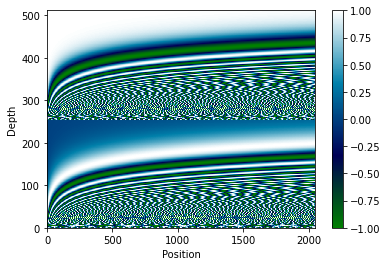

In [21]:
# n is maximum length of a sentence i.e. max position(generally, in power of 2)
# d is dimension of a single token embedding vector(generally, in power of 2)
n, d = 2048, 512

pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding,cmap = 'ocean')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [22]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]
  f = plt.figure()
  f.set_figwidth(80)
  f.set_figheight(10)

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

In [ ]:
sentence = 'declare integer a   input a   print a'
translated = '#include <iostream>  using namespace std; int main(){ int a;  cin>> a;  cout<<a;   return 0;}'

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.prob.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.prob.lookup(in_tokens)[0]
print(in_tokens)

translated_tokens = tf.convert_to_tensor([translated])
translated_tokens = tokenizers.prob.tokenize(translated_tokens).to_tensor()
translated_tokens = tokenizers.prob.lookup(translated_tokens)[0]
print(translated_tokens)

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.prob.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.prob.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(100, 25))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])